Here we compare Solcast Estimated Actuals and Solcast +1h Forecasts to an irradiance measurement timeseries.

In [1]:
import numpy as np
import pandas as pd

from solcast import historic
from solcast.unmetered_locations import UNMETERED_LOCATIONS

## Load Data

Here, we assume that all the measurement timezone, time-period, and quality control work has already been done, so we can get straight to the accuracy assessment.

In [ ]:
# Use an unmetered location to avoid consuming API requests
site = UNMETERED_LOCATIONS["Goodwin Creek"]

In [2]:
resp = historic.radiation_and_weather(
    latitude=site["latitude"],
    longitude=site["longitude"],
    output_parameters=['ghi'],
    start="2023-07-10T00:00:00-05:00",
    end="2023-07-23T00:00:00-05:00",
    period="PT30M",
)
actuals = resp.to_pandas()
actuals.index = actuals.index.tz_convert("-05:00:00")
actuals.head()

,ghi
period_end,
2023-07-10 00:30:00-05:00,0
2023-07-10 01:00:00-05:00,0
2023-07-10 01:30:00-05:00,0
2023-07-10 02:00:00-05:00,0
2023-07-10 02:30:00-05:00,0


Some sample measurements:

In [3]:
meas = pd.read_csv("./data/3.3_sample_measurements.csv", index_col="period_end", parse_dates=True)
meas.tail()

,ghi
period_end,
2023-07-22 22:00:00-05:00,0
2023-07-22 22:30:00-05:00,0
2023-07-22 23:00:00-05:00,0
2023-07-22 23:30:00-05:00,0
2023-07-23 00:00:00-05:00,0


And a +1h forecast timeseries we prepared earlier:

(This could be generated either by setting up a forecast trial, and saving past forecasts, or requesting hindcast data from the Solcast team).

In [4]:
forecast_1h = pd.read_csv("./data/3.3_sample_forecasts.csv", index_col="period_end", parse_dates=True)
forecast_1h.head()

,ghi
period_end,
2023-07-10 00:30:00-05:00,0
2023-07-10 01:00:00-05:00,0
2023-07-10 01:30:00-05:00,0
2023-07-10 02:00:00-05:00,0
2023-07-10 02:30:00-05:00,0


## Combine Data

We combine the measurement, Solcast actuals, and Solcast forecast timeseries together.

- Importantly, we make sure they are on exactly the same timesteps (in this case a day of forecast data is missing). A common error in accuracy assessments is to not assess on exactly the same timesteps - 
- We also drop nighttime steps (`ghi_actuals=0`), as industry standard, because you don't get points for knowing it's nighttime!

,ghi_meas,ghi_actuals,ghi_forecast+1h
period_end,,,
2023-07-10 06:30:00-05:00,16,16,9.0
2023-07-10 07:00:00-05:00,34,41,69.0
2023-07-10 07:30:00-05:00,65,78,98.0
2023-07-10 08:00:00-05:00,69,107,192.0
2023-07-10 08:30:00-05:00,110,136,158.0


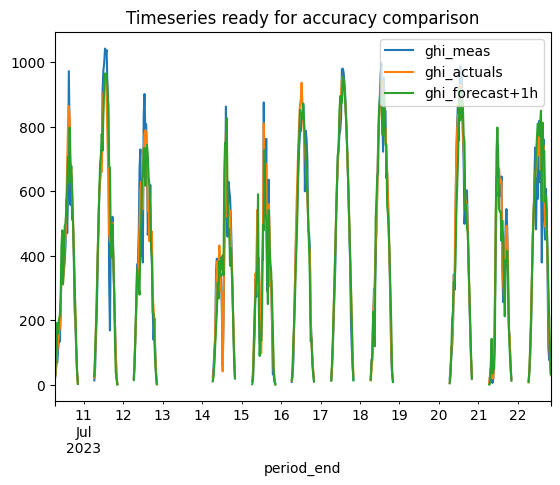

In [5]:
combined = (
    meas.add_suffix("_meas")
    .join(actuals.add_suffix("_actuals"))
    .join(forecast_1h.add_suffix("_forecast+1h"))
)
# match timesteps
combined = combined.dropna(how="any") 
# drop nighttime
combined = combined.query("ghi_actuals > 0")

combined.reindex(
    # fill in missing timesteps with NaN for clearer plotting
    pd.date_range(combined.index.min(), combined.index.max(), freq="30T", name="period_end")
).plot(title="Timeseries ready for accuracy comparison")

combined.head()

## Calculating Overall Metrics

Here we calculate common metrics for irradiance timeseries data:

- nMBE (a.k.a bias%, normalised bias)
- nMAE (a.k.a. mae%, MAPE, nMAD, normalised mean absolute error)
- nRMSE (a.k.a. rmse%, normalised root mean squared error)
- pearson correlation coefficient

For irradiance, it is common to use the mean observation as the normalising factor. Note that for power measurements, it is more common to use the nameplate system capacity as the normalising factor.

-------------------

Note that it is industry practice to **not** scale by the observation on each timestep. This is because you would divide by small value near dawn and dusk, with high relative error but very low actual error, for example:

- here the forecast error is totally neglibile in the first row, but the relative error makes it look enormous, whereas the error in the second row is actually more impactful for most applications

```
measurement |  forecast | absolute error | relative error ( do not use! ) |
    2 W/m^2 |   5 W/m^2 |        3 W/m^2 |                           250% |
  250 W/m^2 | 260 W/m^2 |       10 W/m^2 |                             4% |
```

In [6]:
def calculate_error(df, meas_col, normalising_factor=None):
    if not df.notnull().all().all():
        raise ValueError("null")

    if normalising_factor is None:
        normalising_factor = df[meas_col].mean()
    error = []
    for col in df.columns:
        if col == meas_col:
            continue
        obs = df[meas_col]
        fcs = df[col]
        error.append(
            {
                "nMBE [%]": (fcs - obs).mean() / normalising_factor * 100,
                "nMAE [%]": (fcs - obs).abs().mean() / normalising_factor * 100,
                "nRMSE [%]": ((fcs - obs)**2).mean() ** 0.5 / normalising_factor * 100,
                "correlation": np.corrcoef(fcs.values, obs.values)[0][1],
                "source": col,
            }
        )
    error = pd.DataFrame.from_records(error).set_index("source")
    return error


In [7]:
display(
    calculate_error(combined, meas_col="ghi_meas")
    .round(2)
)


,nMBE [%],nMAE [%],nRMSE [%],correlation
source,,,,
ghi_actuals,2.65,10.59,15.43,0.98
ghi_forecast+1h,1.73,17.48,25.56,0.93


## Daily kWh metrics

Here we calculate daily stats by first converting to daily kWh

<Axes: >

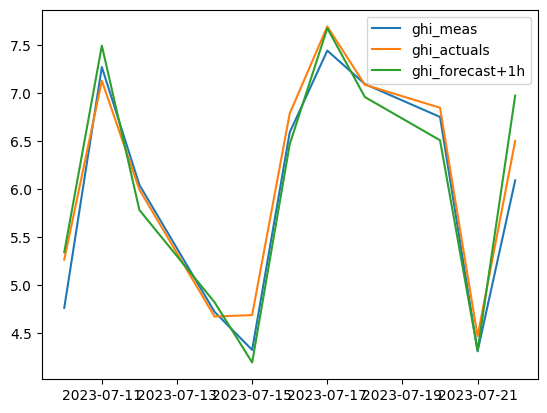

In [8]:
# convert PT30M W/m^2 to kWh
period_minutes = 30
kwh = combined * (period_minutes / 60) / 1000  
kwh_daily = kwh.groupby(combined.index.date).sum()
kwh_daily.plot()

In [9]:
display(
    calculate_error(kwh_daily, meas_col="ghi_meas")
    .round(2)
)


,nMBE [%],nMAE [%],nRMSE [%],correlation
source,,,,
ghi_actuals,2.65,3.41,4.29,0.99
ghi_forecast+1h,1.73,4.47,6.02,0.96
